Import Library

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import copy  # save models

Dataset : BUSI 
In folder have 3 class each class have ultrasound image and Regions of interest(ROI) 

In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split
import glob

def create_train_test_dirs():
    # form base directory for split dataset for training and validation form BUSI dataset
    base_dir = 'data'
    os.makedirs(base_dir, exist_ok=True)
    
    # Create train and validation directories
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # Create subdirectories for each class
    classes = ['normal', 'benign', 'malignant']
    for class_name in classes:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    
    return base_dir, train_dir, val_dir

In [13]:
def split_and_copy_data(source_dir='Dataset_BUSI_with_GT', train_size=0.8):
    base_dir, train_dir, val_dir = create_train_test_dirs()
    classes = ['normal', 'benign', 'malignant']
    
    for class_name in classes:
        # Get all image files (excluding mask files)
        source_path = os.path.join(source_dir, class_name)
        all_files = [f for f in glob.glob(os.path.join(source_path, '*.png')) 
                    if not f.endswith('_mask.png') and not f.endswith('_mask_1.png')]
        
        # Split files into train and validation sets
        train_files, val_files = train_test_split(all_files, 
                                                train_size=train_size,
                                                random_state=42)
        
        # Copy training files
        for f in train_files:
            filename = os.path.basename(f)
            shutil.copy2(f, os.path.join(train_dir, class_name, filename))
            
        # Copy validation files
        for f in val_files:
            filename = os.path.basename(f)
            shutil.copy2(f, os.path.join(val_dir, class_name, filename))
        
        print(f"{class_name}:")
        print(f"Total files: {len(all_files)}")
        print(f"Training files: {len(train_files)}")
        print(f"Validation files: {len(val_files)}\n")
    
    return base_dir

# Call the function to split and organize the dataset
dataset_dir = split_and_copy_data(source_dir='Dataset_BUSI_with_GT', train_size=0.8)

# Update the DATASET_DIR variable in your existing code
DATASET_DIR = dataset_dir

normal:
Total files: 133
Training files: 106
Validation files: 27

benign:
Total files: 438
Training files: 350
Validation files: 88

benign:
Total files: 438
Training files: 350
Validation files: 88

malignant:
Total files: 210
Training files: 168
Validation files: 42

malignant:
Total files: 210
Training files: 168
Validation files: 42



In [14]:
# # Define paths first
# TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
# VAL_DIR = os.path.join(DATASET_DIR, 'val')

# # Your existing data transformation and loading code will work with the new directory structure
# image_datasets = {
#     'train': datasets.ImageFolder(TRAIN_DIR, data_transforms['train']),
#     'val': datasets.ImageFolder(VAL_DIR, data_transforms['val'])
# }

# dataloaders = {
#     'train': torch.utils.data.DataLoader(image_datasets['train'], 
#                                        batch_size=BATCH_SIZE, 
#                                        shuffle=True, 
#                                        num_workers=2),
#     'val': torch.utils.data.DataLoader(image_datasets['val'], 
#                                      batch_size=BATCH_SIZE, 
#                                      shuffle=False, 
#                                      num_workers=2)
# }

In [15]:
# --- 0. Configuration & Hyperparameters ---
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 16
EPOCHS = 50 #จำนวน epochs เริ่มต้น
LEARNING_RATE = 0.001
NUM_CLASSES = 3 #สมมติว่ามี 3 คลาส
DATASET_DIR = 'data' # ชื่อโฟลเดอร์สำหรับข้อมูลจำลอง
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'val')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


 1. Data Preparation & Augmentation

In [16]:
# Data augmentation and normalization for training
# Normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE[0]), # อาจจะ crop ส่วนที่ไม่ต้องการออกไปบ้าง
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Mean and Std for ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Resize( (IMAGE_SIZE[0] + 32, IMAGE_SIZE[1] + 32) ), # Resize ให้ใหญ่กว่า target เล็กน้อย
        transforms.CenterCrop(IMAGE_SIZE[0]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(TRAIN_DIR, data_transforms['train']),
    'val': datasets.ImageFolder(VAL_DIR, data_transforms['val'])
}

# DataLoader จะจัดการเรื่อง batch สุดท้ายที่ไม่เต็มโดยอัตโนมัติ
# หากตั้ง drop_last=True, batch สุดท้ายที่ไม่เต็มจะถูกตัดออก
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Class names: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

# แสดงตัวอย่างขนาดของ batch
inputs_ex, classes_ex = next(iter(dataloaders['train']))
print("Shape of one batch of images (PyTorch):", inputs_ex.shape) # (BATCH_SIZE, Channels, IMG_HEIGHT, IMG_WIDTH)
print("Shape of one batch of labels (PyTorch):", classes_ex.shape) # (BATCH_SIZE)

# คำนวณ Steps per epoch (iterations per epoch)
steps_per_epoch_train_calc = np.ceil(dataset_sizes['train'] / BATCH_SIZE)
steps_per_epoch_val_calc = np.ceil(dataset_sizes['val'] / BATCH_SIZE)
print(f"Calculated steps per epoch for training: {steps_per_epoch_train_calc}")
print(f"Calculated steps per epoch for validation: {steps_per_epoch_val_calc}")



Class names: ['benign', 'malignant', 'normal']
Dataset sizes: {'train': 624, 'val': 157}
Shape of one batch of images (PyTorch): torch.Size([16, 3, 224, 224])
Shape of one batch of labels (PyTorch): torch.Size([16])
Calculated steps per epoch for training: 39.0
Calculated steps per epoch for validation: 10.0
Shape of one batch of images (PyTorch): torch.Size([16, 3, 224, 224])
Shape of one batch of labels (PyTorch): torch.Size([16])
Calculated steps per epoch for training: 39.0
Calculated steps per epoch for validation: 10.0


In [17]:
# --- 2. Model Building (Transfer Learning with ResNet50) ---
# Load ResNet50 pre-trained on ImageNet
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the pre-trained model
for param in model_ft.parameters():
    param.requires_grad = False

# Get the number of input features for the classifier
num_ftrs = model_ft.fc.in_features

# Replace the last fully connected layer with a new one for our number of classes
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256), # สามารถเพิ่ม layer ตรงนี้ได้
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

model_ft = model_ft.to(device) # Send model to GPU if available

# Print model summary (number of parameters)
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters (classifier head): {trainable_params}")


Total parameters: 24033347
Trainable parameters (classifier head): 525315


In [18]:

# --- 3. Define Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=LEARNING_RATE)


In [19]:

# --- 4. Learning Rate Scheduler & Callbacks (Manual Setup) ---
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# More flexible: Reduce learning rate when a metric has stopped improving
lr_plateau_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.2, patience=5, verbose=True)

# For Early Stopping and Model Checkpoint (manual implementation within training loop)
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 10
checkpoint_filepath_pytorch = 'best_medical_resnet_model_pytorch.pth'

d:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# --- 5. Training Loop ---
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Use global variables for checkpointing and early stopping
    global best_model_wts
    global best_val_loss
    global epochs_no_improve

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item()) # .item() to get Python number from tensor
            else: # phase == 'val'
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Learning rate scheduler step (based on validation loss)
                if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                # elif isinstance(scheduler, lr_scheduler.StepLR) and epoch > 0: # StepLR is typically called after optimizer.step()
                    # scheduler.step() # For StepLR, usually called every epoch

                # Early Stopping & Model Checkpoint
                if epoch_loss < best_val_loss:
                    print(f"Validation loss decreased ({best_val_loss:.4f} --> {epoch_loss:.4f}). Saving model ...")
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), checkpoint_filepath_pytorch)
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_val_loss:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

print("\n--- Starting Initial Training (Classifier Head) ---")
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, lr_plateau_scheduler, num_epochs=EPOCHS)



--- Starting Initial Training (Classifier Head) ---
Epoch 1/50
----------
train Loss: 1.0552 Acc: 0.5288
train Loss: 1.0552 Acc: 0.5288
val Loss: 0.7745 Acc: 0.5605
Validation loss decreased (inf --> 0.7745). Saving model ...
val Loss: 0.7745 Acc: 0.5605
Validation loss decreased (inf --> 0.7745). Saving model ...

Epoch 2/50
----------

Epoch 2/50
----------
train Loss: 0.9478 Acc: 0.5721
train Loss: 0.9478 Acc: 0.5721
val Loss: 0.8100 Acc: 0.5924
Validation loss did not improve for 1 epoch(s).

Epoch 3/50
----------
val Loss: 0.8100 Acc: 0.5924
Validation loss did not improve for 1 epoch(s).

Epoch 3/50
----------
train Loss: 0.9177 Acc: 0.5833
train Loss: 0.9177 Acc: 0.5833
val Loss: 0.7830 Acc: 0.6242
Validation loss did not improve for 2 epoch(s).

Epoch 4/50
----------
val Loss: 0.7830 Acc: 0.6242
Validation loss did not improve for 2 epoch(s).

Epoch 4/50
----------
train Loss: 0.8971 Acc: 0.5849
train Loss: 0.8971 Acc: 0.5849
val Loss: 0.7240 Acc: 0.6369
Validation loss decrea


--- Evaluating after initial training (Best Model Loaded) ---
Final Validation Loss (Best Model): 0.6266
Final Validation Accuracy (Best Model): 0.6688
Final Validation Loss (Best Model): 0.6266
Final Validation Accuracy (Best Model): 0.6688


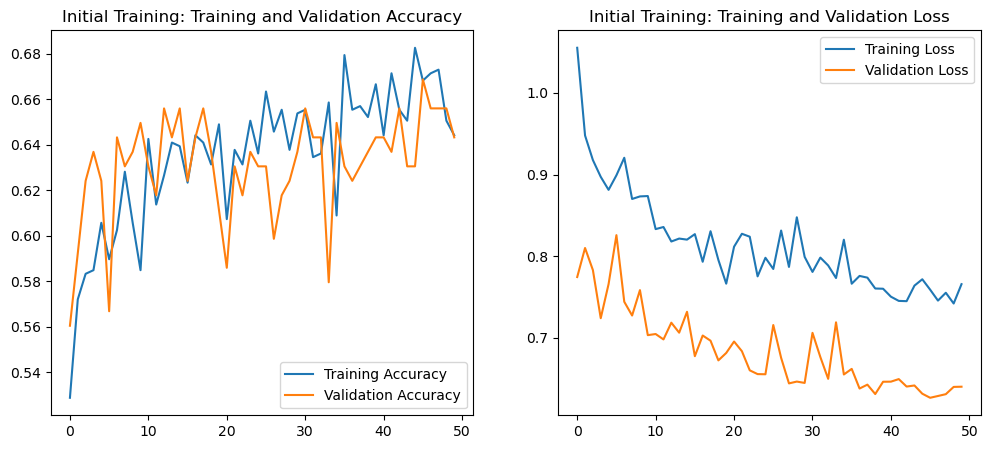

In [23]:

# --- 6. Evaluate after initial training (already done by loading best model in train_model) ---
print("\n--- Evaluating after initial training (Best Model Loaded) ---")
# To explicitly evaluate again if needed:
model_ft.eval() # Set to evaluation mode
val_running_loss = 0.0
val_running_corrects = 0
with torch.no_grad(): # No need to track gradients for evaluation
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

final_val_loss = val_running_loss / dataset_sizes['val']
final_val_acc = val_running_corrects.double() / dataset_sizes['val']
print(f"Final Validation Loss (Best Model): {final_val_loss:.4f}")
print(f"Final Validation Accuracy (Best Model): {final_val_acc:.4f}")


# --- Plot training history ---
def plot_history_pytorch(history_dict, title_prefix=""):
    train_acc = history_dict['train_acc']
    val_acc = history_dict['val_acc']
    train_loss = history_dict['train_loss']
    val_loss = history_dict['val_loss']
    epochs_range = range(len(train_acc)) # Use length of train_acc as num_epochs run

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title_prefix}Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title_prefix}Training and Validation Loss')
    plt.show()

plot_history_pytorch(history_ft, "Initial Training: ")


In [22]:

# --- 7. Fine-tuning (Optional) ---
# Unfreeze some layers of the base model and train with a very low learning rate.

# print("\n--- Starting Fine-tuning Setup ---")
# # Unfreeze all parameters first
# for param in model_ft.parameters():
#     param.requires_grad = True
#
# # Or, more selectively, unfreeze only later layers, e.g., layer4 and fc
# # for name, child in model_ft.named_children():
# #     if name in ['layer3', 'layer4', 'fc']: # Unfreeze these
# #         print(name + ' is unfrozen')
# #         for param in child.parameters():
# #             param.requires_grad = True
# #     else: # Freeze others
# #         print(name + ' is frozen')
# #         for param in child.parameters():
# #             param.requires_grad = False

# # Let's unfreeze all for simplicity in this example for fine-tuning
# for param in model_ft.parameters():
#      param.requires_grad = True

# # Create a new optimizer for fine-tuning with a very low learning rate
# # Important: Pass only trainable parameters to the optimizer
# optimizer_fine_tune = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=LEARNING_RATE / 100)
#
# # Re-initialize early stopping and checkpoint variables for fine-tuning phase
# best_model_wts_ft = copy.deepcopy(model_ft.state_dict()) # Start with current best
# best_val_loss_ft = best_val_loss # Start with current best val_loss
# epochs_no_improve_ft = 0
# early_stop_patience_ft = 10 # Can be different for fine-tuning
# checkpoint_filepath_pytorch_ft = 'best_medical_resnet_model_pytorch_finetuned.pth'
#
# # Need to modify train_model to handle these new global-like variables or pass them
# # For simplicity, one might re-run a similar training loop structure for fine-tuning.
# # Example:
# # model_ft_tuned, history_fine_tune = train_model(
# #     model_ft, criterion, optimizer_fine_tune,
# #     lr_scheduler.ReduceLROnPlateau(optimizer_fine_tune, mode='min', factor=0.2, patience=3, verbose=True),
# #     num_epochs=20 # Fewer epochs for fine-tuning
# # )
# # plot_history_pytorch(history_fine_tune, "Fine-tuning: ")

# # trainable_params_ft = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
# # print(f"Trainable parameters during fine-tuning: {trainable_params_ft}")

print("\nProcess finished.")
# To cleanup dummy data
# if os.path.exists(DATASET_DIR):
#     shutil.rmtree(DATASET_DIR)
#     print(f"Dummy dataset at {DATASET_DIR} removed.")


Process finished.
